# Fill missing LF codes

In [1]:
import numpy as np 
import cartopy
import cartopy.crs as ccrs
import matplotlib
matplotlib.interactive(True)
import cmocean
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
import datetime 
from datetime import date 
import mpl_toolkits.basemap as bm
import matplotlib.animation as animation
import numpy.ma as ma
import matplotlib.cm as cm
from matplotlib.patches import Polygon
from scipy import signal, stats
import time
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings; warnings.simplefilter('ignore')
import seaborn as sns
from functions import trend, load_ice, plot_cartopy
from matplotlib import gridspec

# %matplotlib notebook

path = '/extra-space1/data/tikoralukupload/cis-weekly/nc/'
region = 'HB'

# Projection for mapping
rot = ccrs.RotatedPole(pole_latitude=55,pole_longitude=150)

# Read in data
nc = Dataset(path + region + '.nc', 'r')
lon = nc.variables['longitude'][600:1450,1700:]
lat = nc.variables['latitude'][600:1450,1700:]
juld = nc.variables['juld'][:]
land = nc.variables['land'][:][600:1450,1700:]
E_CT = nc.variables['E_CT'][:,600:1450,1700:]   
E_FA = nc.variables['E_FA'][:,600:1450,1700:]       


CT = np.nan*np.ones(E_CT.shape)
CT[E_CT==1] = 10
CT[E_CT==2] = 20
CT[E_CT==3] = 30
CT[E_CT==4] = 40
CT[E_CT==5] = 50
CT[E_CT==6] = 60
CT[E_CT==7] = 70
CT[E_CT==8] = 80
CT[E_CT==9] = 90
CT[E_CT==10] = 95
CT[E_CT==11] = 100


# Date time information
d0ord = date(1950,1,1).toordinal()
dt_ordinal = d0ord + juld
dates = [date.fromordinal(dt_ordinal[tt]) for tt in range(len(juld))]
months = [dates[tt].month for tt in range(len(juld))]
years = [dates[tt].year for tt in range(len(juld))]
months_unique = np.unique(months)
years_unique = np.unique(years)

In [3]:
CT = np.nan*np.ones(E_CT.shape)
CT[E_CT==1] = 10
CT[E_CT==2] = 20
CT[E_CT==3] = 30
CT[E_CT==4] = 40
CT[E_CT==5] = 50
CT[E_CT==6] = 60
CT[E_CT==7] = 70
CT[E_CT==8] = 80
CT[E_CT==9] = 90
CT[E_CT==10] = 95
CT[E_CT==11] = 100

## Mask coastline

953


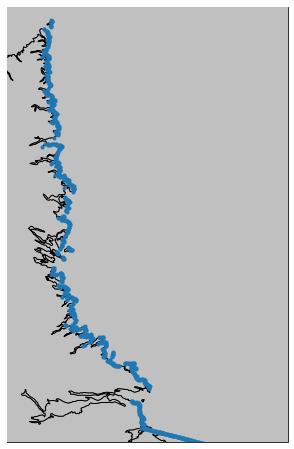

In [4]:
# Get coastline edge
m = np.shape(CT)[2]

coast_i = np.zeros((m))
coast_j = np.zeros((m))

# Mask lon and lat to get land               
ma_lon = ma.masked_array(lon, mask=land)
ma_lat = ma.masked_array(lat, mask=land)


for i in range(m):
    if ma_lon[:,i].count() !=0:
        # Get indef of the first masked value in row i
        first_unmasked = np.where(ma_lon.mask[:,i] == False)[0][0]
        # Array of masked indices in row i
        masked_indices = np.where(ma_lon.mask[:,i] == True)[0]
        # Most eastward point of the coastline in row i
        first_land = masked_indices[np.where(masked_indices > first_unmasked)][0]
        coast_i[i] = i
        coast_j[i] = first_land
        
    else:
        print(i)
        

coast_i = coast_i.astype(int)
coast_j = coast_j.astype(int)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1, projection=rot)
plot_cartopy(ax,lon,lat)
plt.plot(lon[coast_j,coast_i],lat[coast_j,coast_i],'.',transform=ccrs.PlateCarree(),zorder=4)

## Fill missing values that should be LF ice

In [ ]:
# Which month?
mon = 5

CT=E_FA

m = np.shape(CT)[2]
n = np.shape(CT)[1]

sina_ii = np.zeros((m))
sina_jj = np.zeros((m))

sina_i = []
sina_j = []
dates_sina = []
juld_sina = []

for yr in years_unique:
    # Every year for the month defined by mon
    which = (years == yr) * (np.array(months) == mon)
    if np.sum(which) >= 1:
        # Save all observational days of the month
        tt = np.where(which)[0]
    for k in tt:
        sina_ii = np.zeros((m))
        sina_jj = np.zeros((m))
        for i in range(m):
            # Where there is ice
            not_nans = np.where(np.isnan(CT[k,:,i])==False)[0]
            sina_ii[i] = i
            # Check: Is there landfast ice in row i (CT=100)? If yes, save first index as sina point
            if 8 in CT[k,:,i]:
                # Don't count other regions of CT=100. Reverse so coming from west
                sina_point = np.where(CT[k,:,i]==8)[0][0]

                # If the index is more west than the defined coastline, save coastline instead
                if sina_point <= coast_j[i]:
                    sina_jj[i] = sina_point
                else: 
                    sina_jj[i] = coast_j[i]
                
            # SHOULD there be LF ice? (Is there a gap between last CT point and coastline?)
            # Check: Is the coastline at the same location as last ice?
            # First non-nan ice value along j
            
            # Make sure there are non-nan values
            elif 8 not in CT[k,:,i] and len(not_nans)>0:
                last_ice = not_nans[-1]
                # If not at coastline, save as Sina, unless it's too far to be the true Sina (110km)
                if last_ice < coast_j[i]:# and abs(coast_j[i] - last_ice) < 97:
                    sina_jj[i] = last_ice
                else:
               # If the LF ice in CT is more west than the coastline, fill index with coastline coordinate.
                    if ma_lon[:,i].count() !=0: 
                        sina_jj[i] = coast_j[i]
            # If row is all nans:
            else:
                if ma_lon[:,i].count() !=0: 
                    sina_jj[i] = coast_j[i]
                
        sina_ii = sina_ii.astype(int)
        sina_jj = sina_jj.astype(int)
        dates_sina.append(dates[k])
        juld_sina.append(juld[k])
        sina_i.append(sina_ii)
        sina_j.append(sina_jj)